# Programming Club - Regressions in Python using statsmodels and linearmodels
In this notebook, I go through a few ways to estimate regression models in Python - OLS, OLS with cluster-robust standard errors, and a two-way fixed effects model, using [Y, X] and R-style syntax.
I also briefly go over regression diagnostic plots.

In [1]:
'''Importing packages and data preparation'''

import pandas as pd

# Read in SAS data - SNL and IBIS call report data merged with Y-14 operational risk data
df0 = pd.read_sas("~/Desktop/py/data/snlopsrisk_working.sas7bdat")
print("df0 dimensions: ", df0.shape)

# Drop missings
df = df0.dropna()

# Print shape and variable names
print("df dimensions: ", df.shape)
df.columns

df0 dimensions:  (960, 38)
df dimensions:  (780, 38)


Index(['Date', 'ID', 'Institution', 'City', 'Total_Assets_c',
       'Total_Liabilities_c', 'Total_Deposits_c', 'Total_Gross_Loans_c',
       'Total_Net_Loans_c', 'Net_Interest_Margin_c', 'Tier_1_c',
       'NPAs_Assets_c', 'Total_Dividends_Paid_SNL', 'Franchise_Value_c',
       'year', 'Log_Total_Assets', 'Core_to_Total_Dep', 'In_to_Assets_Occr',
       'In_to_Assets_Disc', 'In_to_Assets_Acct', 'Ex_to_Assets_Occr',
       'Ex_to_Assets_Disc', 'Ex_to_Assets_Acct', 'Total_to_Assets_Occr',
       'Total_to_Assets_Disc', 'Total_to_Assets_Acct',
       'In_Exp_to_Assets_OrigA', 'In_Exp_to_Assets_OrigD',
       'In_Exp_to_Assets_OccrA', 'In_Exp_to_Assets_OccrD',
       'Ex_Exp_to_Assets_OrigA', 'Ex_Exp_to_Assets_OrigD',
       'Ex_Exp_to_Assets_OccrA', 'Ex_Exp_to_Assets_OccrD',
       'Total_Exp_to_Assets_OrigA', 'Total_Exp_to_Assets_OrigD',
       'Total_Exp_to_Assets_OccrA', 'Total_Exp_to_Assets_OccrD'],
      dtype='object')

In [2]:
# Which BHCs are we looking at? Do we have balanced panels?
print(df.groupby('Institution')['Date'].nunique())

Institution
b'Bank of America Corporation'            64
b'Bank of New York Mellon Corporation'    35
b'Capital One Financial Corporation'      46
b'Citigroup Inc.'                         64
b'Citizens Financial Group, Inc.'          6
b'Comerica Incorporated'                  64
b'Huntington Bancshares Incorporated'     64
b'JPMORGAN CHASE & CO.'                   62
b'KeyCorp'                                64
b'M&T Bank Corporation'                   64
b'PNC Financial Services Group, Inc.'     57
b'U.S. Bancorp'                           62
b'Wells Fargo & Company'                  64
b'Zions Bancorporation'                   64
Name: Date, dtype: int64


In [3]:
# Override max_columns so no summary statistics are truncated
pd.options.display.max_columns = 40

# Summary statistics
print(df.describe())

                 ID  Total_Assets_c  Total_Liabilities_c  Total_Deposits_c  \
count  7.800000e+02    7.800000e+02         7.800000e+02      7.800000e+02   
mean   1.337076e+06    5.507685e+08         4.985234e+08      2.867227e+08   
std    6.044508e+05    7.237318e+08         6.577198e+08      3.506807e+08   
min    1.027004e+06    2.099656e+07         1.916344e+07      1.451398e+07   
25%    1.068025e+06    6.077213e+07         5.408925e+07      4.500222e+07   
50%    1.073757e+06    1.787445e+08         1.542640e+08      1.153775e+08   
75%    1.199844e+06    7.451082e+08         6.963205e+08      3.546570e+08   
max    3.587146e+06    2.576619e+09         2.340755e+09      1.367887e+09   

       Total_Gross_Loans_c  Total_Net_Loans_c  Net_Interest_Margin_c  \
count         7.800000e+02       7.800000e+02             780.000000   
mean          2.443800e+08       2.384624e+08               3.550069   
std           2.845430e+08       2.768450e+08               1.088946   
min      

### OLS with Y, X style syntax

In [4]:
import statsmodels.regression.linear_model as sm

# Define a function to estimate OLS regression
def fitOLS(varlist, cov='nonrobust'):
    '''
    This function uses statsmodels.OLS (uppercase) to estimate OLS regressions
    using [Y, X] style syntax as opposed to R-style syntax.
    
    Args:
        varlist (list): A list of variables to include in the regression.
        cov      (str): A specific covariance matrix type. Default is 'nonrobust'. 
                        HC0-HC3 available for heteroskedasticity-robust standard errors.
    Returns:
        results: A RegressionResults object which summarizes the fit of a linear regression model.
    '''
    Y = df['Franchise_Value_c']
    X = df[['Log_Total_Assets', 'NPAs_Assets_c', 'Net_Interest_Margin_c', 'Core_to_Total_Dep', 'Tier_1_c']]
    X = sm.add_constant(X)
    for var in varlist:
        X = X.assign(new=df['{}'.format(var)])
        X.rename(columns={'new': '{}'.format(var)}, inplace=True)
    model = sm.OLS(Y, X)
    results = model.fit(cov_type='{}'.format(cov))
    return results

In [5]:
# Fit the model and print results
results = fitOLS(['In_to_Assets_Acct', 'Ex_to_Assets_Acct'])
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      Franchise_Value_c   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     129.1
Date:                Thu, 26 Apr 2018   Prob (F-statistic):          2.39e-125
Time:                        15:41:17   Log-Likelihood:                 1268.1
No. Observations:                 780   AIC:                            -2520.
Df Residuals:                     772   BIC:                            -2483.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.20

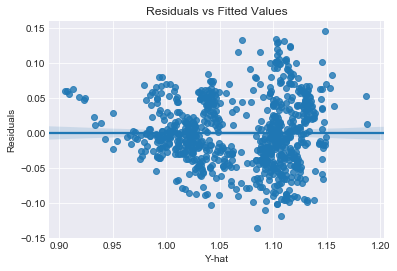

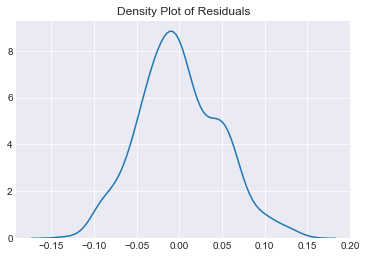

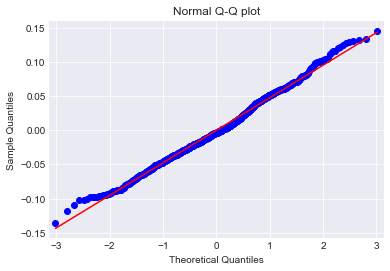

In [6]:
'''Diagnostic plots'''

import statsmodels.graphics.gofplots as gofplots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

# Heteroskedasticity?
plt.title('Residuals vs Fitted Values')
sns.regplot(results.fittedvalues, results.resid)
plt.xlabel('Y-hat')
plt.ylabel('Residuals')
plt.show()

# How are our residuals distributed?
plt.title('Density Plot of Residuals')
sns.kdeplot(results.resid)
plt.show()

# How close are our residuals to normality?
fig = gofplots.qqplot(results.resid, line='s')
plt.title("Normal Q-Q plot")
plt.show()

### OLS with cluster-robust standard errors and R-style syntax

In [7]:
import statsmodels.formula.api as smf

# Define function for running regressions with cluster-robust s.e. using R-style syntax
def clusterOLS(varstring):
    '''
    This function uses statsmodels.ols (lowercase) to estimate OLS regressions
    using R-style syntax as opposed to [Y, X] style syntax. 
    Includes two-way clustering on year and ID.
    
    Args:
        varstring (str): A string containing variables to include in the regression.
                         e.g. 'In_to_Assets_Occr + Ex_to_Assets_Occr'
    Returns:
        results: A RegressionResults object which summarizes the fit of a linear regression model.
    '''
    model = smf.ols(
        'Franchise_Value_c ~ Log_Total_Assets + NPAs_Assets_c + Net_Interest_Margin_c + ' 
        'Core_to_Total_Dep + Tier_1_c + {}'.format(varstring), df)
    results = model.fit(cov_type='cluster', cov_kwds={'groups': (df['year'], df['ID'])}, use_t=True)
    return results

In [8]:
results = clusterOLS("In_to_Assets_Acct + Ex_to_Assets_Acct")
# Instead of printing the summary I call the method directly, which has formatting implications in Jupyter Notebooks
results.summary()

c:\econsw\python36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Franchise_Value_c   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                    -1249.
Date:                Thu, 26 Apr 2018   Prob (F-statistic):               1.00
Time:                        15:41:18   Log-Likelihood:                 1268.1
No. Observations:                 780   AIC:                            -2520.
Df Residuals:                     772   BIC:                            -2483.
Df Model:                           7                                         
Covariance Type:              cluster                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.2084      0.193      6.261      0.000       0.791       1.625
Log_Total_Assets         -0.0016      0.006     -0.258      0.800      -0.015       0.012
NPAs_Assets_c            -0.0347      0.006     -5.997      0.000      -0.047      -0.022
Net_Interest_Margin_c     0.0204      0.007      2.770      0.016       0.004       0.036
Core_to_Total_Dep        -0.0399      0.032     -1.249      0.234      -0.109       0.029
Tier_1_c                 -0.0099      0.002     -5.062      0.000      -0.014      -0.006
In_to_Assets_Acct     -1.786e-06   5.21e-07     -3.429      0.004   -2.91e-06   -6.61e-07
Ex_to_Assets_Acct     -2.825e-06   1.23e-05     -0.229      0.822   -2.95e-05    2.38e-05
==============================================================================
Omnibus:                        7.318   Durbin-Watson:                   0.256
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.463
Skew:                           0.232   Prob(JB):                       0.0240
Kurtosis:                       2.879   Cond. No.                     4.90e+04
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The condition number is large, 4.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Two-way fixed effects

In [9]:
# Linearmodels extends statsmodels, adding capabilities for panel regression, 
# IV estimators, system estimators, and factor asset pricing models
from linearmodels.panel import PanelOLS

# Set hierarchical index for fixed effects estimation [entity, time]
df = df.set_index(['ID', 'Date'])

# add constant
df = sm.add_constant(df)
print("Dimensions should be (780, 37): ", df.shape)

Dimensions should be (780, 37):  (780, 37)


In [10]:
# PanelOLS is a function already defined in the linearmodels package
# I use [Y, X] style syntax, though R syntax is possible using from_formula
model = PanelOLS(df.Franchise_Value_c, 
                 df[['const', 'Log_Total_Assets', 'NPAs_Assets_c', 
                     'Net_Interest_Margin_c', 'Core_to_Total_Dep', 
                     'Tier_1_c', 'In_to_Assets_Acct', 'Ex_to_Assets_Acct']], 
                 entity_effects=True, time_effects=True)
results = model.fit()
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:      Franchise_Value_c   R-squared:                        0.2361
Estimator:                   PanelOLS   R-squared (Between):             -1.9533
No. Observations:                 780   R-squared (Within):               0.5706
Date:                Thu, Apr 26 2018   R-squared (Overall):             -0.2176
Time:                        15:41:19   Log-likelihood                    1831.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      30.726
Entities:                          14   P-value                           0.0000
Avg Obs:                       55.714   Distribution:                   F(7,696)
Min Obs:                       6.0000                                           
Max Obs:                       64.000   F-statistic (robust):             30.726
                            

c:\econsw\python36\lib\site-packages\linearmodels\panel\data.py:258: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  resid = e - d @ np.linalg.lstsq(d, e)[0]
c:\econsw\python36\lib\site-packages\linearmodels\panel\model.py:1020: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(x, y)[0]
c:\econsw\python36\lib\site-packages\linearmodels\panel\model.py:1076: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions

In [11]:
# You can also specify cluster-robust s.e. in a FE model
model = PanelOLS(df.Franchise_Value_c, 
                 df[['const', 'Log_Total_Assets', 'NPAs_Assets_c', 
                     'Net_Interest_Margin_c', 'Core_to_Total_Dep', 
                     'Tier_1_c', 'In_to_Assets_Acct', 'Ex_to_Assets_Acct']], 
                 entity_effects=True, time_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=False, cluster_time=True)
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:      Franchise_Value_c   R-squared:                        0.2361
Estimator:                   PanelOLS   R-squared (Between):             -1.9533
No. Observations:                 780   R-squared (Within):               0.5706
Date:                Thu, Apr 26 2018   R-squared (Overall):             -0.2176
Time:                        15:41:19   Log-likelihood                    1831.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      30.726
Entities:                          14   P-value                           0.0000
Avg Obs:                       55.714   Distribution:                   F(7,696)
Min Obs:                       6.0000                                           
Max Obs:                       64.000   F-statistic (robust):             44.100
                            

c:\econsw\python36\lib\site-packages\linearmodels\panel\data.py:258: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  resid = e - d @ np.linalg.lstsq(d, e)[0]
c:\econsw\python36\lib\site-packages\linearmodels\panel\model.py:1020: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(x, y)[0]
c:\econsw\python36\lib\site-packages\linearmodels\panel\model.py:1076: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions

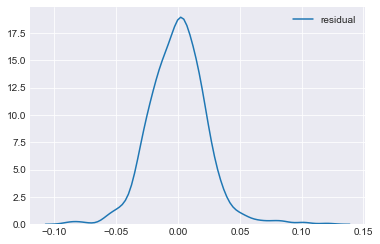

In [14]:
# Using similar but distinct packages can be annoying
# .resid in statsmodels == .residS in linearmodels
sns.kdeplot(results.resids)